<a href="https://colab.research.google.com/github/Unnatiiii44/gitclass/blob/main/pretty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import random
import seaborn as sns

In [ ]:
# 1. LOAD AND PREPROCESS DATA
df = pd.read_csv("/content/smartgrid_merged_dataset.csv")
df_day1 = df[df['Day'] == 1].copy()

# FAST MODE: reduce number of nodes to speed up
df_day1 = df_day1[df_day1['Node_ID'] <= 50]  # limit to 50 nodes for testing

# FIX: ensure unique sources only
sources = df_day1[['Source', 'Capacity_kWh', 'Cost_per_kWh']].drop_duplicates(subset=['Source'])
source_info = sources.set_index('Source').to_dict('index')

nodes = df_day1[df_day1['Source'] == 'Solar'][['Hour', 'Node_ID', 'Demand_kWh']].reset_index(drop=True)
nodes = nodes.groupby(['Hour', 'Node_ID']).sum().reset_index()

num_sources = len(source_info)
num_nodes = nodes['Node_ID'].nunique()
num_hours = nodes['Hour'].nunique()

source_list = list(source_info.keys())

distance_matrix = np.random.uniform(0.01, 0.1, size=(num_nodes, num_sources))

availability = {
    'Solar': [6 <= h <= 18 for h in range(num_hours)],
    'Wind': [True] * num_hours,
    'Hydro': [True] * num_hours
}

In [ ]:
# Simulate distances from each source to each node (line loss factors)
distance_matrix = np.random.uniform(0.01, 0.1, size=(num_nodes, num_sources))  # % loss per unit

# Define hourly availability
availability = {
    'Solar': [6 <= h <= 18 for h in range(num_hours)],
    'Wind': [True] * num_hours,
    'Hydro': [True] * num_hours
}

In [ ]:
# 2. CHROMOSOME ENCODING

def create_chromosome():
    return np.random.rand(num_hours, num_nodes, num_sources)

In [ ]:
# 3. FITNESS FUNCTION
def evaluate_fitness(chromosome):
    total_cost = 0
    penalty = 0

    for hour in range(num_hours):
        for node in range(num_nodes):
            match = nodes[(nodes.Hour == hour) & (nodes.Node_ID == node + 1)]
            if match.empty:
                penalty += 100  # large penalty for missing data
                continue

            demand = match.Demand_kWh.values[0]
            allocation = chromosome[hour, node]

            # Mask unavailable sources
            for i, src in enumerate(source_list):
                if not availability[src][hour]:
                    allocation[i] = 0

            if allocation.sum() == 0:
                penalty += 100
                continue

            allocation = allocation / allocation.sum() * demand

            for i, src in enumerate(source_list):
                src_data = source_info[src]
                cap = src_data['Capacity_kWh']
                cost = src_data['Cost_per_kWh']
                energy = allocation[i]
                loss_factor = distance_matrix[node, i]
                actual_energy = energy * (1 + loss_factor)

                total_cost += actual_energy * cost

                if actual_energy > cap / (num_nodes * num_hours):
                    penalty += 10 * (actual_energy - cap / (num_nodes * num_hours))

    return -(total_cost + penalty)

In [ ]:
# 4. GENETIC ALGORITHM (SERIAL)
def genetic_algorithm_serial(generations=30, pop_size=20, mutation_rate=0.05):
    population = [create_chromosome() for _ in range(pop_size)]
    best_scores = []

    for gen in range(generations):
        fitness_scores = [evaluate_fitness(ind) for ind in population]
        sorted_pop = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]
        population = sorted_pop[:pop_size // 2] * 2

        for i in range(0, pop_size, 2):
            if i+1 < pop_size:
                cross_point = random.randint(0, num_hours - 1)
                temp = population[i][:cross_point].copy()
                population[i][:cross_point] = population[i+1][:cross_point]
                population[i+1][:cross_point] = temp

        for ind in population:
            if random.random() < mutation_rate:
                h, n, s = random.randint(0, num_hours-1), random.randint(0, num_nodes-1), random.randint(0, num_sources-1)
                ind[h][n][s] = random.random()

        best_scores.append(max(fitness_scores))
        print(f"Gen {gen+1}: Best Fitness = {best_scores[-1]:.2f}")

    return best_scores, sorted_pop[0]

In [ ]:
# 5. GENETIC ALGORITHM (PARALLEL)
def evaluate_population(pop):
    with Pool(cpu_count()) as pool:
        results = pool.map(evaluate_fitness, pop)
    return results

def genetic_algorithm_parallel(generations=30, pop_size=20, mutation_rate=0.05):
    population = [create_chromosome() for _ in range(pop_size)]
    best_scores = []

    for gen in range(generations):
        fitness_scores = evaluate_population(population)
        sorted_pop = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]
        population = sorted_pop[:pop_size // 2] * 2

        for i in range(0, pop_size, 2):
            if i+1 < pop_size:
                cross_point = random.randint(0, num_hours - 1)
                temp = population[i][:cross_point].copy()
                population[i][:cross_point] = population[i+1][:cross_point]
                population[i+1][:cross_point] = temp

        for ind in population:
            if random.random() < mutation_rate:
                h, n, s = random.randint(0, num_hours-1), random.randint(0, num_nodes-1), random.randint(0, num_sources-1)
                ind[h][n][s] = random.random()

        best_scores.append(max(fitness_scores))
        print(f"[P] Gen {gen+1}: Best Fitness = {best_scores[-1]:.2f}")

    return best_scores, sorted_pop[0]

In [ ]:
# 6. BASELINE GREEDY METHOD
def baseline_greedy():
    total_cost = 0
    penalty = 0

    for _, row in nodes.iterrows():
        hour = row['Hour']
        node = row['Node_ID'] - 1  # adjust to 0-indexed
        demand = row['Demand_kWh']

        best_cost = float('inf')
        best_energy = 0

        for i, src in enumerate(source_list):
            if not availability[src][hour]:
                continue

            cost = source_info[src]['Cost_per_kWh']
            cap = source_info[src]['Capacity_kWh'] / (num_nodes * num_hours)
            loss = distance_matrix[node, i]
            required_energy = demand * (1 + loss)

            if required_energy > cap:
                continue  # skip over-capacity sources

            est_cost = required_energy * cost
            if est_cost < best_cost:
                best_cost = est_cost
                best_energy = required_energy

        if best_cost == float('inf'):
            penalty += 100  # no valid source available
        else:
            total_cost += best_cost

    return total_cost + penalty

Gen 1: Best Fitness = -159851.40
Gen 2: Best Fitness = -159901.30
Gen 3: Best Fitness = -159901.30
Gen 4: Best Fitness = -159901.30
Gen 5: Best Fitness = -159901.30
Gen 6: Best Fitness = -159901.30
Gen 7: Best Fitness = -159886.05
Gen 8: Best Fitness = -159886.05
Gen 9: Best Fitness = -159886.05
Gen 10: Best Fitness = -159886.05
Gen 11: Best Fitness = -159886.05
Gen 12: Best Fitness = -159885.40
Gen 13: Best Fitness = -159885.40
Gen 14: Best Fitness = -159885.40
Gen 15: Best Fitness = -159885.40
Gen 16: Best Fitness = -159885.40
Gen 17: Best Fitness = -159885.40
Gen 18: Best Fitness = -159885.40
Gen 19: Best Fitness = -159885.40
Gen 20: Best Fitness = -159885.40
[P] Gen 1: Best Fitness = -159995.69
[P] Gen 2: Best Fitness = -159930.84
[P] Gen 3: Best Fitness = -159930.84
[P] Gen 4: Best Fitness = -159930.84
[P] Gen 5: Best Fitness = -159930.84
[P] Gen 6: Best Fitness = -159930.84
[P] Gen 7: Best Fitness = -159930.84
[P] Gen 8: Best Fitness = -159930.84
[P] Gen 9: Best Fitness = -159930

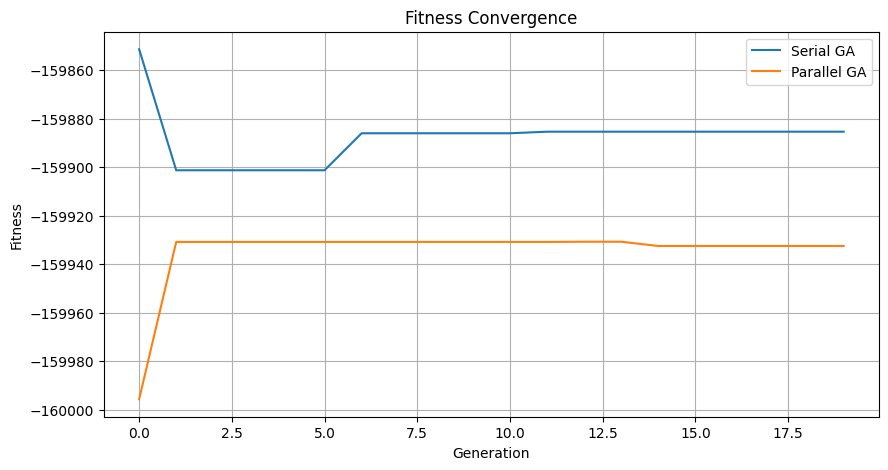


RUNTIME COMPARISON
Serial GA Time: 200.19 seconds
Parallel GA Time: 171.04 seconds
Greedy Baseline Cost: 15000.00


In [ ]:
# 7. RUN AND VISUALIZE
FAST_GENERATIONS = 20
FAST_POP_SIZE = 20

start_serial = time.time()
serial_scores, best_serial = genetic_algorithm_serial(generations=FAST_GENERATIONS, pop_size=FAST_POP_SIZE)
end_serial = time.time()

start_parallel = time.time()
parallel_scores, best_parallel = genetic_algorithm_parallel(generations=FAST_GENERATIONS, pop_size=FAST_POP_SIZE)
end_parallel = time.time()

plt.figure(figsize=(10,5))
plt.plot(serial_scores, label='Serial GA')
plt.plot(parallel_scores, label='Parallel GA')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Convergence')
plt.legend()
plt.grid(True)
plt.show()

print("\nRUNTIME COMPARISON")
print(f"Serial GA Time: {end_serial - start_serial:.2f} seconds")
print(f"Parallel GA Time: {end_parallel - start_parallel:.2f} seconds")
print(f"Greedy Baseline Cost: {baseline_greedy():.2f}")

In [ ]:
import time
start_greedy = time.time()
greedy_cost = baseline_greedy()
end_greedy = time.time()

print(f"Greedy Runtime: {end_greedy - start_greedy:.2f} seconds")

Greedy Runtime: 0.01 seconds


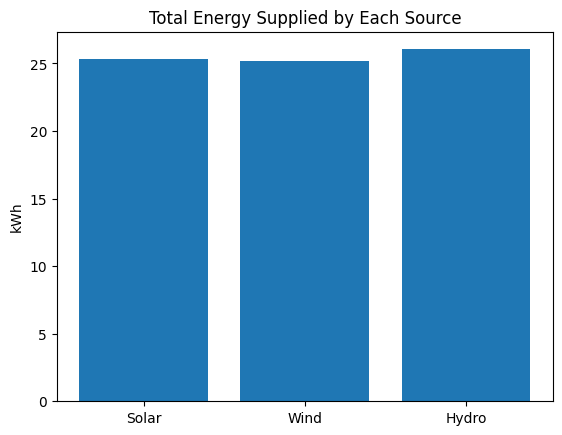

In [ ]:
# Source-wise energy use
avg_alloc = best_parallel.mean(axis=0)  # Mean over hours (axis=0)
total_source_energy = avg_alloc.sum(axis=0)
plt.bar(source_list, total_source_energy)
plt.title("Total Energy Supplied by Each Source")
plt.ylabel("kWh")
plt.show()

In [ ]:
# 8. MUTATION RATE ANALYSIS
def mutation_sensitivity_analysis():
    mutation_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
    best_fitness_per_rate = []

    for rate in mutation_rates:
        print(f"\nRunning GA with mutation rate = {rate}")
        scores, _ = genetic_algorithm_serial(generations=FAST_GENERATIONS, pop_size=FAST_POP_SIZE, mutation_rate=rate)
        best_fitness_per_rate.append(max(scores))

    plt.figure(figsize=(8,5))
    plt.plot(mutation_rates, best_fitness_per_rate, marker='o', linestyle='-', color='purple')
    plt.xlabel('Mutation Rate')
    plt.ylabel('Best Fitness Score')
    plt.title('Mutation Rate vs Fitness Score')
    plt.grid(True)
    plt.show()


Running GA with mutation rate = 0.01
Gen 1: Best Fitness = -159664.42
Gen 2: Best Fitness = -159529.70
Gen 3: Best Fitness = -159529.70
Gen 4: Best Fitness = -159529.70
Gen 5: Best Fitness = -159529.70
Gen 6: Best Fitness = -159529.70
Gen 7: Best Fitness = -159529.70
Gen 8: Best Fitness = -159529.70
Gen 9: Best Fitness = -159529.70
Gen 10: Best Fitness = -159529.70
Gen 11: Best Fitness = -159530.54
Gen 12: Best Fitness = -159530.54
Gen 13: Best Fitness = -159530.54
Gen 14: Best Fitness = -159530.54
Gen 15: Best Fitness = -159530.54
Gen 16: Best Fitness = -159530.54
Gen 17: Best Fitness = -159530.54
Gen 18: Best Fitness = -159530.54
Gen 19: Best Fitness = -159530.54
Gen 20: Best Fitness = -159530.54

Running GA with mutation rate = 0.05
Gen 1: Best Fitness = -159462.30
Gen 2: Best Fitness = -159403.00
Gen 3: Best Fitness = -159403.00
Gen 4: Best Fitness = -159403.00
Gen 5: Best Fitness = -159403.00
Gen 6: Best Fitness = -159403.00
Gen 7: Best Fitness = -159403.00
Gen 8: Best Fitness = 

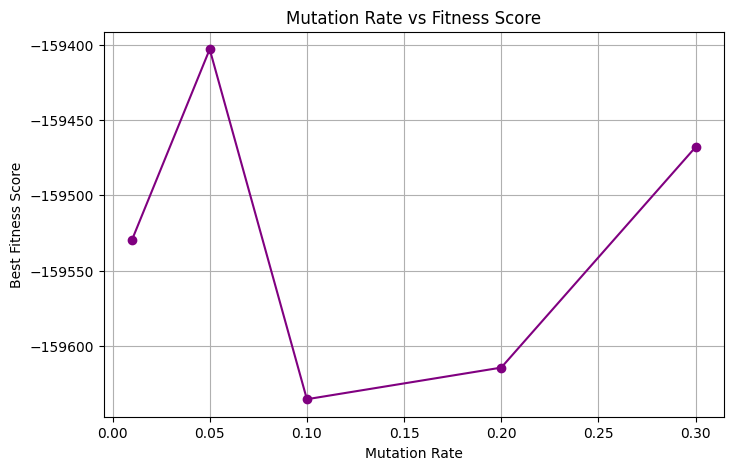

In [ ]:
# 9. CALL ANALYSIS

mutation_sensitivity_analysis()


In [ ]:
import psutil
# 10. CPU & MEMORY USAGE
def print_resource_usage():
    cpu = psutil.cpu_percent()
    mem = psutil.virtual_memory().percent
    print(f"CPU usage: {cpu}%")
    print(f"Memory usage: {mem}%")

print_resource_usage()

CPU usage: 67.7%
Memory usage: 8.2%
